In [1]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from sklearn.cluster import DBSCAN

import geohash2
import pyproj
from pyproj import Proj, transform, CRS
from functools import partial
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geopy.distance import geodesic
from scipy.spatial import cKDTree
from scipy.stats import poisson

import random
import pickle
from tqdm import tqdm
from time import sleep

# Bevölkerungsdemographie

In [ ]:
geo_gdf = gpd.read_file('./Frankfurt_Data/geo_frankfurt.gpkg')

bevölkerungs_gdf = gpd.read_file('./Frankfurt_Data/pharmacy_assigned_complete.gpkg')
bevölkerungs_gdf['Alter'] = bevölkerungs_gdf['Alter'].apply(json.loads)
bevölkerungs_gdf['Geschlecht'] = bevölkerungs_gdf['Geschlecht'].apply(json.loads)

customers_gdf = gpd.read_file('./Frankfurt_Data/cluster_frankfurt.gpkg')
customers_gdf['Alter'] = customers_gdf['Alter'].apply(json.loads)

In [ ]:
# Funktion zum Berechnen des Durchschnittsalters
def calculate_average_age(age_dict):
    age_ranges = list(age_dict.keys())
    age_counts = list(age_dict.values())
    age_midpoints = [np.mean(list(map(int, age_range.split('-')))) if '-' in age_range else 80 for age_range in age_ranges]
    weighted_sum = sum(midpoint * count for midpoint, count in zip(age_midpoints, age_counts))
    total_count = sum(age_counts)
    average_age = weighted_sum / total_count if total_count != 0 else 0
    return average_age

In [ ]:
bevölkerungs_gdf['average_age'] = bevölkerungs_gdf['Alter'].apply(calculate_average_age)
customers_gdf['average_age'] = customers_gdf['Alter'].apply(calculate_average_age)

In [ ]:
# Berechne die Gesamtanzahl je Altersgruppe
age_ranges = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80+"]
total_counts = {age_range: 0 for age_range in age_ranges}
for age_dict in customers_gdf['Alter']:
    for age_range, count in age_dict.items():
        total_counts[age_range] += int(count)

average_age_overall = customers_gdf['average_age'].mean()

# Erstelle eine benutzerdefinierte Farbkarte
colors = plt.cm.coolwarm(np.linspace(0, 1, len(age_ranges)))
cmap = ListedColormap(colors)

# Zuordnung der Farben zu Altersabschnitten
age_color_map = {age_range: color for age_range, color in zip(age_ranges, colors)}

# Plot
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the raster with boundary
geo_gdf.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plot the customers with custom colormap based on average age
bevölkerungs_gdf.plot(ax=ax, column='average_age', cmap=cmap, markersize = 1.5)

# Add title and labels
plt.axis('off')

# Add custom legend for age ranges with total counts and average age
handles = [Patch(color=age_color_map[age_range], label=f"{age_range}: {total_counts[age_range]}") for age_range in age_ranges]
handles.append(Patch(color='none', label=f"Ø: {average_age_overall:.2f}"))
legend = ax.legend(handles=handles, title="Altersabschnitte | Einwohnerzahl", loc='center left', bbox_to_anchor=(0.9, 0.9), frameon=False)

# Setze die Texte der Legende linksbündig
plt.setp(legend.get_texts(), ha='left')

# Add scale bar
scalebar = ScaleBar(1, location='lower right', label='Maßstab')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.show()

# Cluster Graphics

In [ ]:
gdf_city = gpd.read_file('./99_Old/Wuerzburg/Raster_Wuerzburg.gpkg')
geo_gdf = gpd.read_file('./Wuerzburg_Data/geo_wuerzburg.gpkg')

In [ ]:
# Extrahieren der Polygon-Koordinaten als Features für das Clustering
X = np.array(gdf_city.geometry.apply(lambda polygon: [polygon.centroid.x, polygon.centroid.y]).tolist())

# DBSCAN-Clustering durchführen
dbscan = DBSCAN(eps=100, min_samples=4)  # Anpassen von eps und min_samples je nach Bedarf
dbscan.fit(X)

# Fügen Sie die Cluster-Zuordnung als neue Spalte zum GeoDataFrame hinzu
gdf_city['cluster'] = dbscan.labels_

In [ ]:
# Funktion, um einen Teil einer Colormap zu extrahieren
def truncate_colormap(cmap, minval=0.4, maxval=1.0, n=100):
    new_cmap = plt.cm.colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})', 
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [ ]:
def get_middle_indices(cluster_sizes, n):
    """
    Gibt die Indizes der mittleren n Cluster zurück.
    """
    sorted_indices = cluster_sizes.sort_values().index
    middle_start = (len(sorted_indices) - n) // 2
    middle_end = middle_start + n
    return sorted_indices[middle_start:middle_end][::-1]

In [ ]:
# Funktion zum Berechnen der Anzahl der Einwohner und Polygone für jeden Cluster
def get_cluster_info(cluster_id):
    population = int(gdf_city[gdf_city["cluster"] == cluster_id]["INSGESAMT_0"].sum())
    num_polygons = len(gdf_city[gdf_city["cluster"] == cluster_id])
    return population, num_polygons

In [ ]:
# Funktion zur Erzeugung von Abständen
def format_label(cluster_id, population, num_polygons):
    cluster_id_str = f'Cluster {cluster_id}:'
    population_str = f'{population}'
    num_polygons_str = f'|   {num_polygons * 10000 / 1000000}km²'
    
    if len(str(cluster_id)) < 2:
        population_pos = 17  # Abstand von Cluster ID
    elif len(str(cluster_id)) < 3:
        population_pos = 16  # Abstand von Cluster ID
    else:
        population_pos = 15  # Abstand von Cluster ID

    if len(str(population)) < 3:
        num_polygons_pos = population_pos + 11  # Abstand von Population
    elif len(str(population)) < 4:
        num_polygons_pos = population_pos + 10  # Abstand von Population
    elif len(str(population)) < 5:
        num_polygons_pos = population_pos + 9  # Abstand von Population
    elif len(str(population)) < 6:
        num_polygons_pos = population_pos + 8  # Abstand von Population
    else:
        num_polygons_pos = population_pos + 7  # Abstand von Population
    
    label = f'{cluster_id_str:<{population_pos}}{population_str:<{num_polygons_pos - population_pos}}{num_polygons_str}'
    return label

In [ ]:
# Gruppiere die Polygone nach Cluster-ID und vereinige sie zu MultiPolygons
cluster_multipolygons = gdf_city.dissolve(by='cluster')
# Erstelle einen neuen GeoDataFrame (optional, falls weitere Modifikationen nötig sind)
gdf_clusters = gpd.GeoDataFrame(cluster_multipolygons, geometry='geometry')
gdf_clusters['color_int'] = gdf_clusters.apply(lambda x: random.randint(1, len(gdf_clusters)), axis=1)

# Verwende den helleren Teil der cividis-Colormap
cmap = truncate_colormap(plt.get_cmap('viridis'), 0.2, 1.0)

# Berechne die Clustergröße
cluster_sizes = gdf_city[gdf_city['cluster'] != -1]['cluster'].value_counts()
# Filtere die 3 größten Cluster
largest_clusters = cluster_sizes.nlargest(3).index.tolist()
# Filtere die 3 kleinsten Cluster
smallest_clusters = cluster_sizes.nsmallest(3).index.tolist()
# Berechne die mittleren Cluster, indem du die größten und kleinsten entfernst
remaining_clusters = cluster_sizes[~cluster_sizes.index.isin(largest_clusters + smallest_clusters)]
middle_clusters = get_middle_indices(remaining_clusters, 4).tolist()
# Kombiniere die Cluster in einer Liste
selected_clusters = largest_clusters + middle_clusters + smallest_clusters

# Anzahl der Polygone im Cluster -1
outlier_count = len(gdf_city[gdf_city['cluster'] == -1])

# Plotten der Boundary
fig, ax = plt.subplots(figsize=(7, 7))
geo_gdf.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotten der Polygone mit Cluster-Färbung
gdf_clusters[gdf_clusters.index != -1].plot(ax=ax, column='color_int', cmap=cmap, legend=False)
gdf_city[gdf_city['cluster'] == -1].plot(ax=ax, color='purple', legend=False)  # Lila für Cluster -1


# Zentroiden und Anzahl der Polygone der 10 größten Cluster anzeigen
for cluster_id in selected_clusters:
    cluster_data = gdf_city[gdf_city['cluster'] == cluster_id]
    centroid = cluster_data.geometry.unary_union.centroid
    ax.plot(centroid.x, centroid.y, '^', color='red', markersize=6)
    if cluster_id == 89:
        ax.text(centroid.x - 1600, centroid.y - 800, cluster_id, fontsize=12, ha='center', va='center', color='black', fontweight='bold') 
    else:
        ax.text(centroid.x + 1600, centroid.y - 800, cluster_id, fontsize=12, ha='center', va='center', color='black', fontweight='bold')  # Versetzte Position


# Text unterhalb der Farblegende hinzufügen
fig.text(1.285, 0.5772, f'Fläche der Ausreiser: {outlier_count* 10000 / 1000000}km²', ha='right', va='center', fontsize=9)
fig.text(1.23, 0.5555, f'Anzahl der Cluster: {gdf_city["cluster"].nunique()-1}', ha='right', va='center', fontsize=9)

# Erstelle die Legende
legend_handles = []
for cluster_id in selected_clusters:
    population, num_polygons = get_cluster_info(cluster_id)
    cluster_label = format_label(cluster_id, population, num_polygons)
    legend_handles.append(
        Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label=cluster_label)
    )

# Annahme: ax ist bereits definiert und Plot ist erstellt
legend2 = ax.legend(handles=legend_handles, title='Cluster: Einwohnerzahl | Fläche', bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0., fontsize='small', ncol=1,  alignment='center', frameon=False)
ax.add_artist(legend2)

# Add scale bar
scalebar = ScaleBar(1, location='lower right', label='Maßstab')
ax.add_artist(scalebar)

plt.axis('off')
plt.tight_layout()
plt.show()

# Pharmacy/Warehouse Graphics

In [ ]:
geo_gdf = gpd.read_file('./Donner_Data/geo_donner.gpkg')

pharmacy_df = pd.read_csv('./Donner_Data/donner-Apotheken.csv')
pharmacy_gdf = gpd.GeoDataFrame(pharmacy_df, geometry=gpd.points_from_xy(pharmacy_df['lon'], pharmacy_df['lat']), crs=CRS("EPSG:4326"))
pharmacy_gdf = pharmacy_gdf.to_crs('3035')

warehouses_gdf = gpd.read_file('./Donner_Data/warehouses_donner.gpkg')
warehouses_gdf['month_rent'] = warehouses_gdf['floorSpace_small'] * warehouses_gdf['pricePerSquareMetre']

In [ ]:
# Berechne die durchschnittlichen monatlichen Mietkosten
warehouses_gdf['avg_monthly_rent'] = ((warehouses_gdf['total_price_small'] + warehouses_gdf['total_price_big']) / 2) / 12

# Min- und Max-Werte der "avg_monthly_rent" Spalte
vmin = warehouses_gdf['avg_monthly_rent'].min()
vmax = warehouses_gdf['avg_monthly_rent'].max()
cmap = 'coolwarm'

# Berechne die Größe der Punkte basierend auf der durchschnittlichen Fläche (floorSpace_small und floorSpace_big)
avg_floorSpace = (warehouses_gdf['floorSpace_small'] + warehouses_gdf['floorSpace_big']) / 2
min_size = 15
max_size = 200
size = np.interp(avg_floorSpace, (avg_floorSpace.min(), avg_floorSpace.max()), (min_size, max_size))

# Berechne die tatsächliche maximale und minimale Punktgröße auf der Karte
max_point_size = size[np.argmax(avg_floorSpace)]
min_point_size = size[np.argmin(avg_floorSpace)]

# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(9, 9))
geo_gdf.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte pharmacy_gdf auf dieselbe Achse
pharmacy_gdf.plot(ax=ax, markersize=12, marker='^', color='purple', label='Apotheken')

# Plotte warehouses_gdf auf dieselbe Achse
warehouses_gdf.plot(ax=ax, column='avg_monthly_rent', cmap=cmap, markersize=size, marker='o', legend=False, alpha=0.6, edgecolor='black', linewidth=0.5)

# Titel hinzufügen
plt.axis('off')

# Add colorbar
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.23)
cbar.set_label('Mietkosten der Mindestfläche', fontsize='small', weight='normal')

# Add custom legend for warehouse sizes and types
custom_legend = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='purple', markersize=10, label=f'Apotheken: {len(pharmacy_gdf)}'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label=f'Versandlager: {len(warehouses_gdf)}')
]
# Berechne interpolierte Punktgrößen für die Legende
legend_sizes = [6, 11, 16]
legend_labels = [int(avg_floorSpace.min()), int(avg_floorSpace.median()), int(avg_floorSpace.max())]

# Erstelle die Größenskala für die Legende untereinander mit Farbverlauf von blue zu lightblue zu lightred
colors = ['lightblue', 'lightblue', 'lightblue']
size_legend = []
for size_label, label, color in zip(legend_sizes, legend_labels, colors):
    size_legend.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=size_label, label=f'{label} m²'))

# Hinzufügen der kombinierten Legende
legend1 = ax.legend(handles=custom_legend, title='Versandlager / Apotheken', bbox_to_anchor=(1, 0.98), loc='upper left', borderaxespad=0., fontsize='small', ncol=1, frameon=False, prop={'size': 'small', 'weight': 'normal'})
ax.add_artist(legend1)

# Erstelle die Legende mit den Punkten untereinander und genügend Abstand zwischen den Zeilen
legend2 = ax.legend(handles=size_legend, title='Ø - Fläche der Versandlager', bbox_to_anchor=(1, 0.85), loc='upper left', borderaxespad=0., fontsize='small', ncol=1, handleheight=2.25, handletextpad=1.25, frameon=False, prop={'size': 'small', 'weight': 'normal'})
ax.add_artist(legend2)

# Setze die Font-Eigenschaften der Titel und Texte der Legenden
plt.setp(legend1.get_title(), fontsize='small', fontweight='normal')
plt.setp(legend1.get_texts(), fontsize='small', fontweight='normal')
plt.setp(legend2.get_title(), fontsize='small', fontweight='normal')
plt.setp(legend2.get_texts(), fontsize='small', fontweight='normal')

# Add scale bar
scalebar = ScaleBar(1, location='lower right', label='Maßstab')
ax.add_artist(scalebar)

fig.text(0.95, 0.5772, f'Fläche der Ausreiser: {outlier_count* 10000 / 1000000}km²', ha='right', va='center', fontsize=0.0000000001, color = 'white')

# Zeige den Plot an
plt.show()

# Optimal Warehouse Graphics

In [11]:
geo_gdf = gpd.read_file('./Frankfurt_Data/geo_frankfurt.gpkg')
warehouses_gdf = gpd.read_file('./Frankfurt_Data/warehouses_frankfurt.gpkg')

with open('./Results/optimal_run_results.pkl', 'rb') as infile:
    optimal_results = pickle.load(infile)

opened_warehouses = optimal_results[2]['result_list'][0]['results']['opened_warehouses']
warehouse_info = optimal_results[2]['result_list'][0]['results']['Warehouse Info']

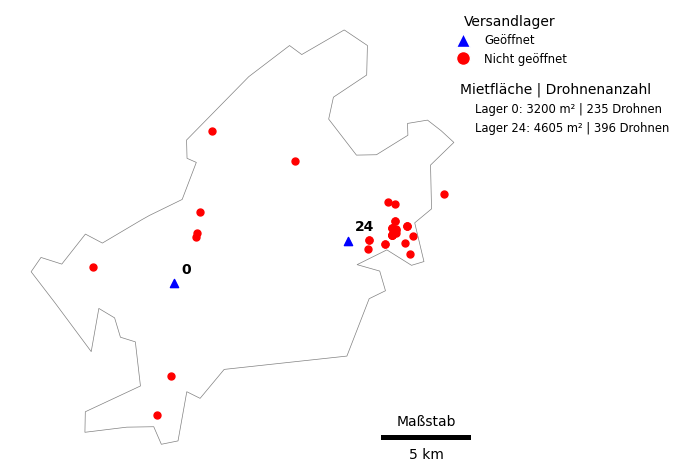

In [13]:
# Rahmen der Grafik definieren
ax = geo_gdf.boundary.plot(color='gray', linewidth=0.5, figsize=(6, 6))

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf[~warehouses_gdf.index.isin(opened_warehouses)].plot(ax=ax, color='red', marker='o', markersize=25)
warehouses_gdf.loc[opened_warehouses].plot(ax=ax, color='blue', marker='^', markersize=35)

plt.axis('off')

# Add scale bar
scalebar = ScaleBar(1, location='lower right', label='Maßstab')
ax.add_artist(scalebar)

# Erste Legende
custom_legend = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label='Geöffnet'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Nicht geöffnet')
]
legend1 = ax.legend(handles=custom_legend, title='Versandlager', bbox_to_anchor=(0.94, 1), loc='upper left', borderaxespad=0., fontsize='small', ncol=1, frameon=False)
ax.add_artist(legend1)

# Zweite Legende
legend_handles = [
    Line2D(
        [0], [0], marker='^', color='w', markersize=0.001,
        label=f'Lager {warehouse}: {info["floor_space_assigned"]} m² | {info["number_of_drones"]} Drohnen'
    )
    for warehouse, info in warehouse_info.items()
]
legend2 = ax.legend(handles=legend_handles, title='Mietfläche | Drohnenanzahl', bbox_to_anchor=(0.92, 0.85), loc='upper left', borderaxespad=0., fontsize='small', ncol=1, frameon=False)

# Index jedes Warehouses anzeigen
for idx, row in warehouses_gdf.loc[opened_warehouses].iterrows():
    plt.annotate(idx, (row.geometry.x, row.geometry.y + 200), xytext=(5, 5), textcoords='offset points', fontsize=10, color='black', fontweight='bold')

# for idx, row in warehouses_gdf[~warehouses_gdf.index.isin(opened_warehouses)].iterrows():
#     plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')


# Zeige den Plot an
plt.show()

# Region Warehouse Solution Graphics

In [20]:
geo_gdf = gpd.read_file('./Donner_Data/geo_donner.gpkg')
warehouses_gdf = gpd.read_file('./Donner_Data/warehouses_donner.gpkg')
customers_gdf = gpd.read_file('./Results/Optimal_Results_customers_donner.gpkg')
customers_gdf['Alter'] = customers_gdf['Alter'].apply(json.loads)

with open('./Results/optimal_run_results.pkl', 'rb') as infile:
    optimal_results = pickle.load(infile)

opened_warehouses = optimal_results[1]['result_list'][0]['results']['opened_warehouses']

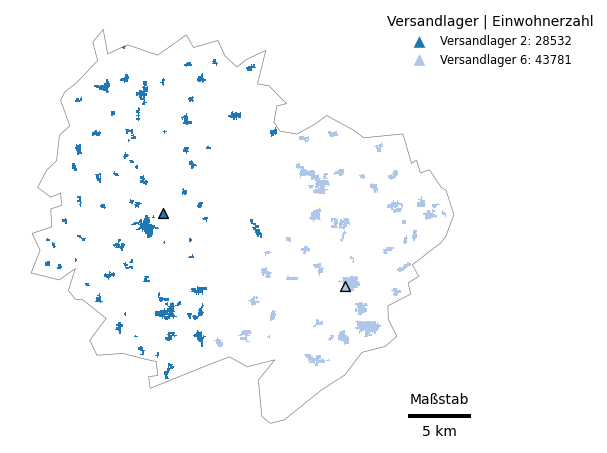

In [23]:
# Erstellen einer Farbkarte ohne Grautöne
tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
filtered_colors = np.array([color for color in tab20_colors if not np.allclose(color[:3], 0.6)])  # Filter out gray

colors = filtered_colors[:len(opened_warehouses)]
warehouse_colors = dict(zip(opened_warehouses, colors))

# Create a dictionary to map each warehouse to a color
warehouse_colors = {
    warehouse: color
    for warehouse, color in zip(opened_warehouses, warehouse_colors.values())
}

# Plot the boundaries of the region
ax = geo_gdf.boundary.plot(color='gray', linewidth=0.5, figsize=(6, 6))


# Plot the customers with the color of their assigned warehouse
for index, row in customers_gdf.iterrows():
    warehouse = row['assigned_warehouse']
    color = warehouse_colors.get(warehouse, 'gray')  # Use gray color if warehouse is not in the dictionary
    customers_gdf.iloc[[index]].plot(ax=ax, color=color, markersize=25)


# Plot the warehouses with their assigned colors
for warehouse, color in warehouse_colors.items():
    warehouses_gdf[warehouses_gdf.index == warehouse].plot(ax=ax, color=color, marker='^', markersize=50, edgecolor='black')


# Turn off axis
plt.axis('off')

# Add legend
# Erstelle die Legende
legend_handles = [
    Line2D(
        [0], [0], marker='^', color='w', markerfacecolor=color, markersize=10,
        label=f'Versandlager {warehouse}: {int(customers_gdf[customers_gdf["assigned_warehouse"] == warehouse]["sum_INSGESAMT_0"].sum())}'
    )
    for warehouse, color in warehouse_colors.items()
]
ax.legend(handles=legend_handles, title='Versandlager | Einwohnerzahl', bbox_to_anchor=(0.8, 1), loc='upper left', borderaxespad=0., fontsize='small', ncol=1, frameon=False)

# Add scale bar
scalebar = ScaleBar(1, location='lower right', label='Maßstab')
ax.add_artist(scalebar)

# Show the plot
plt.show()

# Tabellenerstellung 

In [7]:
with open('./Results/sensitivity_results.pkl', 'rb') as infile:
    sensitivity_results = pickle.load(infile)

with open('./Results/optimal_run_results.pkl', 'rb') as infile:
    optimal_results = pickle.load(infile)

In [5]:
city = ['wuerzburg', 'donner', 'frankfurt']

for i in range(3):
    opened_warehouses = optimal_results[i]['result_list'][0]['results']['opened_warehouses']
    optimal_solution_counter = 0
    solution_dict = []
    for j in range(i*16, i*16+16):
        for item in sensitivity_results[j]['result_list']:
            if np.array_equal(item['opened_warehouses'], opened_warehouses):
                optimal_solution_counter+=1
            else:
                solution_dict.append(
                    {
                        'parameter': item['parameter_name'],
                        'parameter_value': item['parameter_value'],
                        'opened_warehouses': item['opened_warehouses'],
                        'number_of_drones':  item['number_of_drones'],
                        'floor_space_assigned': item['floor_space_assigned'],
                        'warehouse_info': item['Warehouse Info']
                    }
                )

    solution_dict.append({
        'optimal_count': optimal_solution_counter
    })
    with open(f'./Results/solution_dict_{city[i]}.pkl', 'wb') as outfile:
        pickle.dump(solution_dict, outfile)


In [2]:
factory_fix_costs = 50000
factory_variable_costs = 0.5
factory_operating_costs = 0.375
qm_per_customer = 0.5
minimum_square_requirement = 750
rent_factor = 1
max_flight_distance = 20
drone_initial_costs = 4000
drone_speed = 65/60
time_window = 630
delivery_time = 60
alpha = 0.3
night_shift_dist = 0.00112103746
demand_factor = 1
watt_drone = 1.08
kwh_eur = 0.25

optimal_parameter_values = {
    'factory_fix_costs': factory_fix_costs,
    'factory_variable_costs': factory_variable_costs,
    'factory_operating_costs': factory_operating_costs,
    'qm_per_customer': qm_per_customer,
    'minimum_square_requirement': minimum_square_requirement,
    'rent_factor': rent_factor,
    'max_flight_distance': max_flight_distance,
    'drone_initial_costs': drone_initial_costs,
    'drone_speed': drone_speed,
    'time_window': time_window,
    'delivery_time': delivery_time,
    'alpha': alpha,
    'night_shift_dist': night_shift_dist,
    'demand_factor': demand_factor,
    'watt_drone': watt_drone,
    'kwh_eur': kwh_eur
}

In [3]:
def sort_based_on_reference(data, optimal_parameter_values):
    grouped_data = defaultdict(list)

    # Group the entries by parameter
    for entry in data:
        if 'parameter' in entry:
            param = entry['parameter']
            grouped_data[param].append(entry)

    sorted_data = []

    # Sort each parameter group
    for param, entries in grouped_data.items():
        below_optimal = []
        above_optimal = []
        optimal_value = optimal_parameter_values[param]

        for entry in entries:
            value = entry['parameter_value']

            if value < optimal_value:
                entry['change'] = 'lower'
                below_optimal.append(entry)
            else:
                entry['change'] = 'higher'
                above_optimal.append(entry)

        # Sort the data below the optimal value in descending order
        below_optimal_sorted = sorted(below_optimal, key=lambda x: x['parameter_value'], reverse=True)
        # Sort the data above the optimal value in ascending order
        above_optimal_sorted = sorted(above_optimal, key=lambda x: x['parameter_value'])

        # Combine the sorted data for the current parameter
        sorted_data.extend(below_optimal_sorted + above_optimal_sorted)

    return sorted_data

In [4]:
def create_latex_table(sorted_data):
    parameter_save = []
    # Erzeuge die LaTeX-Tabelle
    table_header = '''

\\begin{table}[H]
\\centering
\\begin{tabular}{|l|l|l|l|l|l|}
\\hline
\\textbf{Parameter} & \\textbf{Value} & \\textbf{Opened Warehouses} & \\textbf{Number of Drones} & \\textbf{Floor Space Assigned}  \\\\
\\hline
'''

    table_footer = '''
\\end{tabular}
\\caption{Parameter changes affecting warehouse configurations.}
\\end{table}

'''

    table_body = ''

    # Vergleichsarray
    comparison_opened_warehouses = optimal_results[2]['result_list'][0]['results']['opened_warehouses']
    

    for entry in sorted_data:
        param = entry['parameter']
        value = entry['parameter_value']
        opened_warehouses = entry['opened_warehouses']
        number_of_drones = entry['number_of_drones']
        floor_space_assigned = entry['floor_space_assigned']

        if np.array_equal(opened_warehouses, comparison_opened_warehouses):
            continue  # Überspringe, wenn keine Änderung

        comparison_opened_warehouses = opened_warehouses

        ow_str = ', '.join(map(str, opened_warehouses)) if len(opened_warehouses) > 0 else 'None'
        ow_str = ow_str

        nd_str = str(number_of_drones)
        nd_str = nd_str 

        fsa_str = str(floor_space_assigned)
        fsa_str = fsa_str

        table_body += f'{param} & {value:.2f} & {ow_str} & {nd_str} & {fsa_str} \\\\ \\hline\n'

        parameter_save.append({
            param: value
        })

    return table_header + table_body + table_footer, parameter_save

In [20]:
with open('./Results/solution_dict_frankfurt.pkl', 'rb') as infile:
    solution = pickle.load(infile)

In [21]:
sorted_solution = sort_based_on_reference(solution, optimal_parameter_values)
latex_table, parameter_save = create_latex_table(sorted_solution)

In [22]:
print(latex_table)



\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|l|l|}
\hline
\textbf{Parameter} & \textbf{Value} & \textbf{Opened Warehouses} & \textbf{Number of Drones} & \textbf{Floor Space Assigned}  \\
\hline
qm_per_customer & 0.46 & 2, 6, 24 & 621 & 6835 \\ \hline
qm_per_customer & 0.41 & 6, 24 & 733 & 5980 \\ \hline
qm_per_customer & 0.37 & 2, 6, 19 & 670 & 5551 \\ \hline
qm_per_customer & 0.60 & 0, 2, 24 & 568 & 9080 \\ \hline
qm_per_customer & 0.68 & 0, 2, 18, 24 & 549 & 9966 \\ \hline
qm_per_customer & 0.75 & 0, 2, 19, 24 & 562 & 11018 \\ \hline
max_flight_distance & 8.82 & 1, 6, 24 & 709 & 9705 \\ \hline
max_flight_distance & 8.12 & 0, 1, 19 & 751 & 8491 \\ \hline
max_flight_distance & 5.00 & None & 0 & 0 \\ \hline
time_window & 60.00 & 0, 2, 24 & 1490 & 8935 \\ \hline
demand_factor & 0.85 & 0, 19 & 631 & 6274 \\ \hline
demand_factor & 0.80 & 6, 24 & 584 & 5856 \\ \hline
demand_factor & 0.70 & 2, 6, 19 & 472 & 5111 \\ \hline
demand_factor & 1.21 & 0, 2, 24 & 681 & 9176 \\ \hline
deman

In [20]:
with open(f'./Results/parameter_comparison_frankfurt.pkl', 'wb') as outfile:
    pickle.dump(parameter_save, outfile)

# Tests

In [ ]:
with open('./Results/cost_comparison_frankfurt_complete_final.pkl', 'rb') as infile:
    cost_comp = pickle.load(infile)

In [ ]:
cost_comp

In [ ]:
keys = ['rental_cost', 'factory_fix_monthly', 'factory_variable_monthly', 'factory_operating_monthly', 'drone_setup_cost']

for item in cost_comp:
    compared_costs = item['compared_costs']
    for key, value in compared_costs['optimal'].items():
        if key in keys:
            compared_costs['optimal'][key] = value / 15

    for key, value in compared_costs['sensitiv'].items():
        if key in keys:
            compared_costs['sensitiv'][key] = value / 15

In [ ]:
with open('./Results/cost_comparison_donner_complete_time_fixed.pkl', 'rb') as infile:
    cost_comp = pickle.load(infile)

In [ ]:
cost_comp

In [ ]:
with open('./Results/parameter_comparison_wuerzburg.pkl', 'rb') as infile:
    cost_comp = pickle.load(infile)

In [ ]:
cost_comp